Import Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from lmfit import Model

# Load the .mqa file
path = 'C:/Natuurkunde/NSP2/Data/Data_cilinder_met_water/cilinder_met_water_52cm.mqa' 
df = pd.read_csv(path, sep='\t', header=0)

Cut data and calculate $s$

In [119]:
# Prepare the time and distance (s) arrays for fitting
time = df['Time']
x_position = df['Point #1.X']
y_position = df['Point #1.Y']

# Manually specify the begin and end indices
start_index = 0
end_index = 150

# Slice the data based on the manually specified range
time_selected = time.iloc[start_index:end_index].reset_index(drop=True)
x_position_selected = x_position.iloc[start_index:end_index].reset_index(drop=True)
y_position_selected = y_position.iloc[start_index:end_index].reset_index(drop=True)

# Adjust the data to start at (0, 0)
x_position_adjusted = x_position_selected - x_position_selected.iloc[0]
y_position_adjusted = y_position_selected - y_position_selected.iloc[0]
time_selected = time_selected - time_selected.iloc[0]

# Calculate s (distance in centimeters) for each time
s = np.sqrt(x_position_adjusted**2 + y_position_adjusted**2)

Error calculation ($s$)

In [120]:
def xy_err():
    # Import calibration data
    path = 'C:/Natuurkunde/NSP2/Data/calibratie_err_s.mqa' 
    df = pd.read_csv(path, sep='\t', header=0)

    # Assign columns
    x_position_cal = df['Point #1.X']
    y_position_cal = df['Point #1.Y']
    
    # Manually specify the begin and end indices
    start_index = 1 
    end_index = 1528

    # Slice the data based on the manually specified range
    x_position_cal_selected = x_position_cal.iloc[start_index:end_index].reset_index(drop=True)
    y_position_cal_selected = y_position_cal.iloc[start_index:end_index].reset_index(drop=True)
    
    # Find maximal and minimal values in datasets
    x_max = np.max(x_position_cal_selected)
    x_min = np.min(x_position_cal_selected)
    y_max = np.max(y_position_cal_selected)
    y_min = np.min(y_position_cal_selected)
    
    # Find error on x and y in cm
    err_x = (x_max - x_min) / 2
    err_y = (y_max - y_min) / 2
    #print(err_x, err_y)
    return err_x, err_y
    
# Calculate error on s in cm
def s_err():
    err_s = []
    err_x, err_y = xy_err()
    for x, y in zip(x_position_adjusted, y_position_adjusted):
        if x > 0 and y < 0:
            err_s.append(np.sqrt(((x**2)/(x**2 + y**2)) * err_x + ((y**2)/(x**2 + y**2)) * err_y)) 
    return err_s

# Display results
err_s = s_err()


Fit value for $a$

In [121]:
# Define the theoretical function for fitting
def theoretical_s(t, a, t_0):
    return 0.5 * a * (t - t_0) ** 2

# Use lmfit Model to define the model and fit the data
model = Model(theoretical_s)
params = model.make_params(a=1, t_0=0)  # Initial guess for parameters

# Ensure consistent lengths for time_selected, s, and err_s
err_s = s_err()
min_length = min(len(time_selected), len(s), len(err_s))
time_selected = time_selected[:min_length]
s = s[:min_length]
err_s = err_s[:min_length]

# Add weights
weights = 1 / np.array(err_s)

# Fit the model to the data
result = model.fit(s, params, t=time_selected, weights = weights)

# Print the fit report, which includes the fitted parameters and reduced chi-squared
print(result.fit_report())

[[Model]]
    Model(theoretical_s)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 144
    # variables        = 2
    chi-square         = 1048.30227
    reduced chi-square = 7.38241038
    Akaike info crit   = 289.856409
    Bayesian info crit = 295.796036
    R-squared          = 0.98879919
[[Variables]]
    a:    229.248076 +/- 0.81026109 (0.35%) (init = 1)
    t_0: -0.02017977 +/- 0.00118749 (5.88%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, t_0) = +0.9696


Plot Graph ($s$,$t$)

Filtered lengths: time_selected=142, s=142, err_s=142


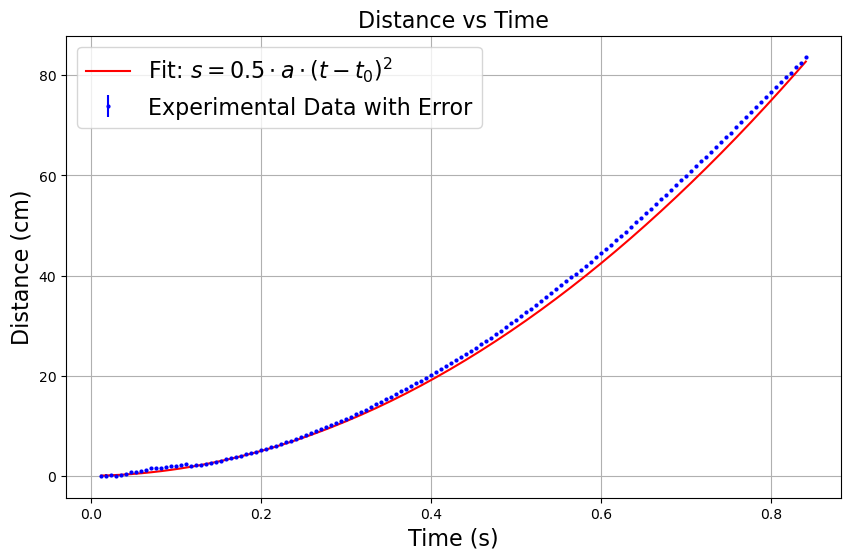

In [122]:
# Ensure all lists are the same length before filtering
min_length = min(len(time_selected), len(s), len(err_s))
time_selected = time_selected[:min_length]
s = s[:min_length]
err_s = err_s[:min_length]

# Filter time_selected, s, and err_s based on non-zero values in s
filtered_data = [
    (t, si, err) for t, si, err in zip(time_selected, s, err_s) if si != 0
]

if not filtered_data:
    raise ValueError("No valid data points left after filtering!")

# Unpack the filtered data into separate lists
time_selected, s, err_s = zip(*filtered_data)

# Convert filtered data back to lists
time_selected = list(time_selected)
s = list(s)
err_s = list(err_s)

# Check lengths after filtering
print(f"Filtered lengths: time_selected={len(time_selected)}, s={len(s)}, err_s={len(err_s)}")

# Plot the data
plt.figure(figsize=(10, 6))
plt.errorbar(time_selected, s, yerr=err_s, fmt='bo', markersize=2, label='Experimental Data with Error')
plt.plot(time_selected, result.best_fit[:len(time_selected)], 'r-', label=r'Fit: $s = 0.5 \cdot a \cdot (t - t_0)^2$')
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Distance (cm)', fontsize=16)
plt.title('Distance vs Time', fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()
